# Maternal Smoking and Birth Weight



## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_statsmodels.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_birth_weight_lower",
    "ex3_smoking_coefficient",
    "ex4_smoking_coefficient",
    "ex6_compare_white_black",
    "ex6_compare_white_black_tstat",
    "ex7_predictions",
    "ex8_smoking_coefficient",
    "ex10_num_high_drug_arrest",
    "ex11_diff_in_diff",
    "ex12_diff_in_diff_weighted",
}
```


### Submission Limits

Please remember that you are **only allowed three submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.


## Exercises

For these exercises, we will borrow some data and exercises from another MIDS course on Statistical Modeling:

These days, it is widely understood that mothers who smoke during pregnancy risk exposing their babies to many health problems. This was not common knowledge fifty years ago. One of the first studies that addressed the issue of pregnancy and smoking was the Child Health and Development Studies, a comprehensive study of all babies born between 1960 and 1967 at the Kaiser Foundation Hospital in Oakland, CA. The original reference for the study is Yerushalmy (1964, American Journal of Obstetrics and Gynecology, pp. 505-518). The data and a summary of the study are in Nolan and Speed (2000, Stat Labs, Chapter 10) and can be found at [the book’s website.](https://www.stat.berkeley.edu/users/statlabs/)

There were about 15,000 families in the study. We will only analyze a subset of the data, in particular 1236 male single births where the baby lived at least 28 days. The researchers interviewed mothers early in their pregnancy to collect information on socioeconomic and demographic characteristics, including an indicator of whether the mother smoked during pregnancy. The variables in the dataset are described in the [code book here](https://ids-702-f19.github.io/Course-Website/hw/hw-02.html). In this exercise, we will attempt to use this data to answer the following questions:

1. Do mothers who smoke tend to give birth to babies with lower weights than mothers who do not smoke?
2. What is a likely range for the difference in birth weights for smokers and non-smokers?
3. Is there any evidence that the association between smoking and birth weight differs by mother’s race? If so, characterize those differences.
4. Are there other interesting associations with birth weight that are worth mentioning?


### Exercise 1
Load the data "smoking.csv", which includes information on both biometrics of infants at birth, and information on mothers (variables prefixed with the letter "m"), from [this MIDS repo](https://github.com/nickeubank/MIDS_Data). (Yup, I'm giving you CLEAN DATA! I think this is the only time I've done this in this course! Enjoy it. :)).

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn.objects as so
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pd.set_option("mode.copy_on_write", True)
smoking = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/blob/master/smoking.csv?raw=true"
)
results = {}
smoking.head()

,id,date,gestation,bwt.oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke
0,4604,1598,148,116,7,7,28,1,66,135,2,0
1,7435,1527,181,110,7,7,27,1,64,133,1,0
2,7722,1563,204,55,11,7,35,3,65,140,6,0
3,2026,1503,225,132,4,7,28,2,67,148,3,0
4,3553,1638,233,105,4,7,34,3,61,130,3,0


### Exercise 2

Start by plotting the relationship between infant weight at birth and gestation (length of pregnancy (in days) at time of birth) for both mothers who smoke and those who do not in a single plot. Include regression lines for both populations (again, all on one plot).

Limit attention in the plot (and in subsequent questions) to children born after *more than* 225 days of gestation (there aren't really any observations for parents who smoke for less than that, so we don't get common support).

Does it seem like birthweights tend to be lower for the children of parents who smoke at a given gestational period? Store your answer as either `"yes"` or `"no"` in `ex2_birth_weight_lower`.

**NOTE:** This dataset has at least one column name that cause issues with Python (and seaborn. and statsmodels).

In [2]:
smoking["smoke"] = smoking["smoke"].astype("bool")
smoking_subset = smoking[smoking["gestation"] > 225]
smoking_subset.head()

,id,date,gestation,bwt.oz,parity,mrace,mage,med,mht,mpregwt,inc,smoke
4,3553,1638,233,105,4,7,34,3,61,130,3,False
5,3491,1705,234,85,7,7,33,1,67,130,2,False
6,6757,1444,234,97,0,6,26,5,65,112,6,False
7,6153,1405,235,129,3,7,24,4,66,135,1,False
8,8187,1669,236,63,0,5,24,5,58,99,7,False


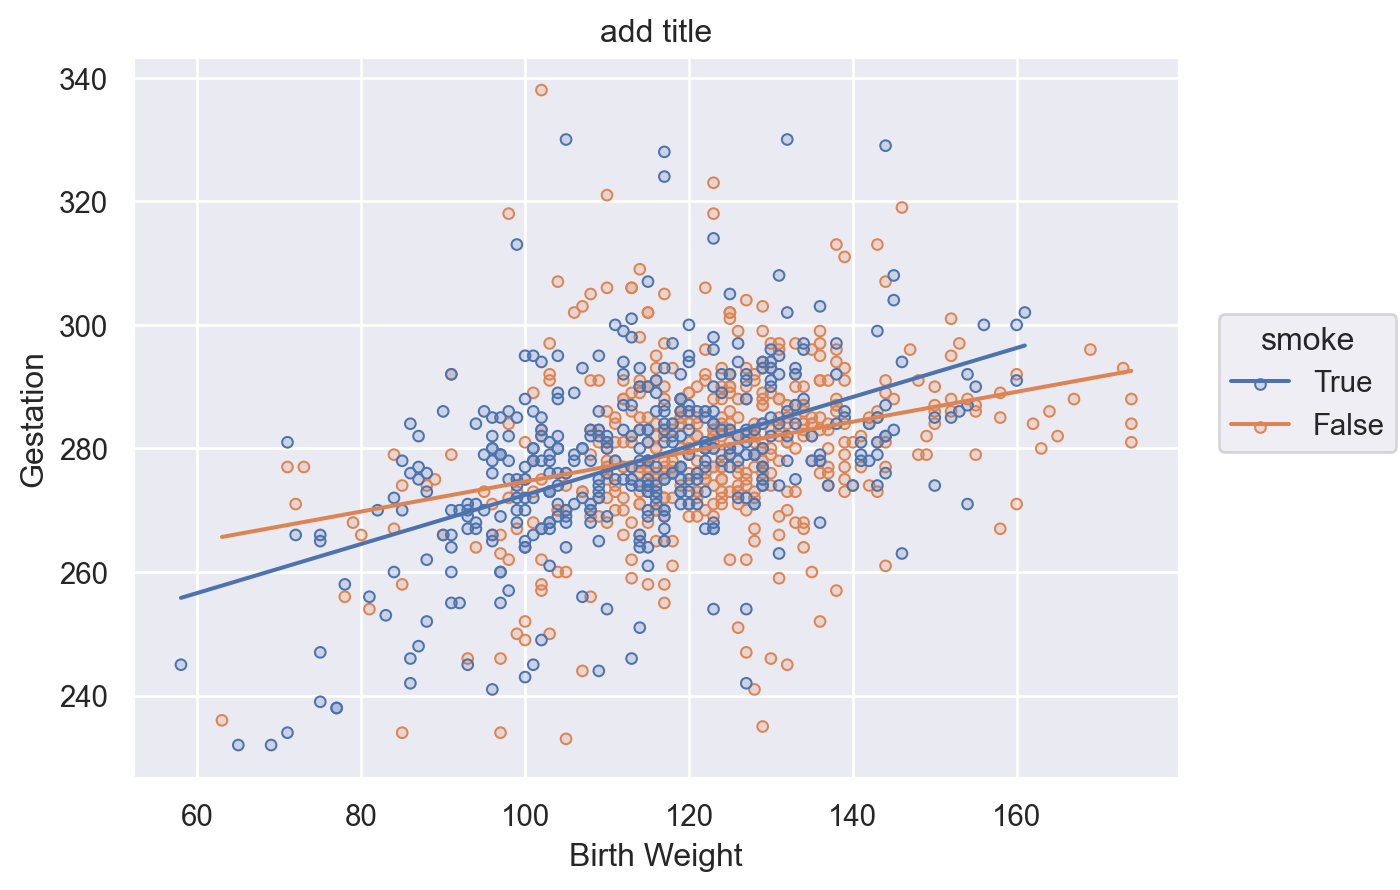

In [3]:
import warnings
import numpy as np
import seaborn.objects as so

warnings.simplefilter(action="ignore", category=FutureWarning)
(
    so.Plot(smoking_subset, x="bwt.oz", y="gestation", color="smoke")
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(order=1))
    .label(
        x="Birth Weight",
        y="Gestation",
        title="add title",
    )
)

In [4]:
ex2_birth_weight_lower = "yes"
results["ex2_birth_weight_lower"] = ex2_birth_weight_lower

## Linear Regression

**PLEASE CONTINUE TO SUBSET FOR GESTATION GREATER THAN 225 DAYS for this section**

### Exercise 3
Now check this relationship using `statsmodels`. Regress birthweight on gestational period and whether the infant's mother smoked. Is your conclusion from the previous exercise confirmed? Store the coefficient for smoking in results under the key `"ex3_smoking_coefficient"`. 

*Note:* coefficients are stored in the `.params` attribute of your fit model.

*Note 2:* you may hit a problem because of the name of one of your columns. You should probably be able to guess the problem given your experience with Python. Also, if you have trouble figuring out how to access the parameters from a fitted model, check out the docs [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html).


In [5]:
smoking_subset.rename(columns={"bwt.oz": "birth_weight_ounces"}, inplace=True)

ex3_ols = smf.ols("birth_weight_ounces ~ gestation + smoke", data=smoking_subset).fit()

ex3_smoking_coefficient = ex3_ols.params["smoke[T.True]"]

print(
    f"The coefficient for smoking in the birthweight regression is: {ex3_smoking_coefficient:.2f}"
)

The coefficient for smoking in the birthweight regression is: -7.88


### Exercise 4
Now let's expand our model to also take into account mothers' pregnancy weight and race (make sure to treat race as a categorical variable!). Don't try to do any recoding of `mrace`, just turn it into a categorical. Does your interpretation of the `smoke` coefficient change? Store the new coefficient under the key `"ex4_smoking_coefficient"`.

In [6]:
ex4_ols = smf.ols(
    "birth_weight_ounces ~ gestation + mpregwt + smoke + C(mrace)", data=smoking_subset
).fit()

ex4_smoking_coefficient = ex4_ols.params["smoke[T.True]"]

print(
    f"After expanding the model to include mothers' pregnancy weight and race, the smoking coefficient is: {ex4_smoking_coefficient:.2f}"
)

After expanding the model to include mothers' pregnancy weight and race, the smoking coefficient is: -7.90


### Exercise 5
Now let's test for whether there is an interaction between the mother's race and the effect of smoking. 

Note that race is coded as follows:

```
mrace    mother’s race or ethnicity
         0-5= white
         6  = mexican
         7 = black
         8 = asian
         9 = mix
         99 = unknown
```

As most variation in this data is between "white" and other categories, first recode race to be an indicator for white and non-white for easier interpretation. 

In [7]:
def map_mrace(x):
    return True if 0 <= x <= 5 else False


smoking_subset["mrace"] = smoking_subset["mrace"].map(map_mrace)

ex5_ols = smf.ols(
    "birth_weight_ounces ~ gestation + mpregwt+ smoke*C(mrace)", data=smoking_subset
).fit()

### Exercise 6
Now, using [post-regression test syntax](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.t_test.html) (not by running a new regression on a subpopulation), recover the coefficient and t-statistic for *whether smoking reduces birth weight for white mothers.*  Store the t-statistic of your test in `ex6_compare_white_black_tstat`.

**Hint:** Read to the BOTTOM of the post-regression test syntax documentation for how to specify hypotheses with strings.

How does this coefficient compare to that for non-white mothers? Is the reduction in birth weight associated with smoking for white mothers larger or smaller than for non-white mothers? Store your answer as either `"larger"` or `"smaller"` under the key `"ex6_compare_white_black"`.

**Note:** Please ensure your t-stat is stored as a single number, not an array or an array of arrays.

In [8]:
hypothesis = "smoke[T.True] + smoke[T.True]:C(mrace)[T.True] = 0"

t_test = ex5_ols.t_test(hypothesis)

ex6_compare_white_black_tstat = t_test.tvalue[0][0]

print(
    f"The t-statistic for testing whether smoking reduces birth weight for white mothers is: {ex6_compare_white_black_tstat:.2f}"
)

ex6_compare_white_black = "larger" if ex6_compare_white_black_tstat > 0 else "smaller"
print(
    f"The reduction in birth weight associated with smoking for white mothers is {ex6_compare_white_black} than for non-white mothers."
)

The t-statistic for testing whether smoking reduces birth weight for white mothers is: -6.27
The reduction in birth weight associated with smoking for white mothers is smaller than for non-white mothers.


### Exercise 7
Now let's use this model to predict some values. Let's generate some hypothetical newborns:

```python
newborns = pd.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "white": [True, False, True, False],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)
```

Using the model you ran above with gestation, smoke, mpregwt, white, and the interaction of white and smoke, predict birth weights for these newborns. Store your predictions **in a list** under the key `"ex7_predictions"`.

Note that if you have different data types from those in this pretend dataset or different column names from those in the dataset you used to fit your model, you’ll get an error—just adjust the column names / data types to match the data you used to fit your model.

In [9]:
newborns = pd.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "white": [True, False, True, False],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)
newborns.rename(columns={"white": "mrace"}, inplace=True)

newborns["smoke"] = newborns["smoke"].astype("bool")

In [10]:
ex7_predictions = list(ex5_ols.predict(newborns))
print(ex7_predictions)

[104.52308427743132, 119.63915539293328, 111.20881028285166, 124.03909471463491]


## statsmodels versus R

A quick but important note: the tools that are made available in different packages is often a function of who uses those packages, and how they use them. By and large, nearly all statisticians use R, and so many stats tools (like automatic forward-model-selection or backwards-model-selection) have "convenience implementations" (single functions that do all the things you'd want to accomplish) in R, but aren't available as convenience packages in `statsmodels`. That's because `statsmodels` was mostly written by economists and social scientists who tend to feel model selection should be a function of theory not statistical performance (not taking sides: just reporting a difference that exists). 

To be clear, you can still implement things like forward model selection yourself in Python -- just write a loop that tries different regressors and plots the resulting AICs! -- but it will often take a little more work. (Indeed, you can find examples of people [writing these loops on the web](https://planspace.org/20150423-forward_selection_with_statsmodels/)). And that's not to say that `statsmodels` doesn't have a TON of stuff (take a minute to just look over all the [examples of cool things you can do in statsmodels here](http://www.statsmodels.org/stable/examples/index.html)). Just don't be surprised if you ommissions that seem odd given what you see emphasized in stats courses. 

This is one of the reasons that languages are sticky: once a group of people have invested in adding all the bells and whistles they like to a language, there are good reasons to not move to another language, even if the other language has some advantages. A statistician who likes the basic language organization of Python more than R, for example, may still stay with R because the packages already do everything a statistician wants to do, and so it's not worth having to re-implement common tasks in a new language. 

## Logistic Regression

### Exercise 8
Now, using statsmodels, evaluate the impact of smoking on the likelihood a child is born prematurely (where "premature" is defined as gestation of *less than* 252 days).

For obvious reasons, **DO NOT USE OUR SUBSET FOR GESTATION GREATER THAN 225 DAYS** from above for this section.

For this model, please include mother’s pre-pregnancy weight, smoking status, and whether the mother is White (if you use all the racial categories, the model won’t converge). Please don’t include the interaction we used in the last question. Store the coefficient for smoking in `ex8_smoking_coefficient`.

In [11]:
smoking_subset2 = smoking.copy()


def is_premature(x):
    return 1 if x < 252 else 0


smoking_subset2["premature"] = smoking_subset2["gestation"].apply(is_premature)

smoking_subset2.rename(columns={"bwt.oz": "birth_weight_ounces"}, inplace=True)


def is_mrace_valid(x):
    return 0 <= x <= 5


smoking_subset2["mrace"] = smoking_subset2["mrace"].apply(is_mrace_valid)

ex8_logit = smf.logit(
    "premature ~ mpregwt + smoke + C(mrace)", data=smoking_subset2
).fit()

ex8_smoking_coefficient = ex8_logit.params["smoke[T.True]"]

print(
    f"The coefficient for smoking in the model predicting premature births is: {ex8_smoking_coefficient:.2f}"
)

Optimization terminated successfully.
         Current function value: 0.187899
         Iterations 7
The coefficient for smoking in the model predicting premature births is: 0.43


## Weighting

Let's now try using statsmodels on another dataset.

In our merging exercises, we ran a difference-in-difference analysis on crime in California counties to see if, following drug legalization, there was a larger decline in violent crime in counties that had previously also had high drug arrest rates (to test the idea that violence was being generated by the drug trade, and that legalization would decrease this violence).

In those analyses, we treated counties as equally-weighted units of analysis. If we think that each county is a single "community", and we think crime and arrests is shaped at the level of communities (particularly when our community division is related to administrative boundaries that impact policing and government services, and is the case with counties), then this is reasonable.

But one might think that crime is determined at the individual level, or maybe neighborhood level, and so big counties should "count more" in our analysis.

(More formally, when we are fitting a regression model that picks parameter values to minimize the overall sum of squared errors, maybe we should pick values that to a better job of minimizing the errors for populous counties at the expense of not doing quite as good a job of minimizing the errors for smaller counties)

Here, let's use weighted least squares to weight observations based on population. This will allow bigger counties to influence our estimates more.

### Exercise 9
To begin, read in our data on California arrest rates and population from [github](https://github.com/nickeubank/MIDS_Data/blob/master/arrest_rates_and_population.parquet). You will see I've reshaped the data to long format for convenience. This data is stored as a parquet file, so you'll need to install an engine (I usually use `fastparquet` to load the data).


In [12]:
arrest_data = pd.read_parquet(
    "https://github.com/nickeubank/MIDS_Data/raw/master/arrest_rates_and_population.parquet"
)

### Exercise 10
To run our difference-in-difference in a regression framework, we need both an indicator variable for observations that occur after legalization (i.e. year == 2018), and an indicator for the population we consider treated (those who had drug arrest rates above the average 2009 drug arrest rate). Re-create those here. 

As a check, store the number of counties that have a high drug arrest rate in 2009 under the key `"ex10_num_high_drug_arrest"`.

*Note:* if you want, you can also use the 2009 drug arrest rates as a continuous variable. This is a kind of "generalized difference-in-difference", in which we're just doing the continuous analogue of the thing we do when we split the sample into "high" and "low" 2009 arrest rates. 

In [13]:
arrest_data["legalization"] = arrest_data["year"].apply(lambda x: int(x >= 2018))
arrest_data_subset = arrest_data[arrest_data["year"] == 2009]

avg_drug_arrest_2009 = arrest_data_subset["drug_arrest_rate"].mean()

In [14]:
# Adding the "treated" column based on arrest rates higher than average in 2009
arrest_data_subset["treated"] = arrest_data_subset["drug_arrest_rate"].apply(
    lambda x: int(x >= avg_drug_arrest_2009)
)
arrest_data_subset["treated"].value_counts()

0    35
1    23
Name: treated, dtype: int64

In [15]:
ex9_high_subset = arrest_data_subset[arrest_data_subset["treated"] == 1]
arrest_data["treated"] = arrest_data["COUNTY"].apply(
    lambda x: int(x in ex9_high_subset["COUNTY"].values)
)
ex10_num_high_drug_arrest = arrest_data_subset[arrest_data_subset["treated"] == True][
    "treated"
].count()

print(
    f"Number of counties with a high drug arrest rate in 2009 among treated counties: {ex10_num_high_drug_arrest}"
)

Number of counties with a high drug arrest rate in 2009 among treated counties: 23


### Exercise 11

Now regression the violent arrest rate on your two indicators and their interaction. The coefficient on the interaction is your "difference-in-difference" estimate! If you go back to your old homeworks, you should find the coefficient is exactly what you calculated. Store this coefficient under the key  `"ex11_diff_in_diff"`.

In [16]:
ex11_ols = smf.ols(
    "violent_arrest_rate ~ legalization + treated + legalization*treated",
    data=arrest_data,
).fit()

ex11_diff_in_diff = ex11_ols.params["legalization:treated"]

print(
    f"The difference-in-difference coefficient for the impact of legalization on violent arrest rate is: {ex11_diff_in_diff:.6f}"
)

The difference-in-difference coefficient for the impact of legalization on violent arrest rate is: -0.000247


### Exercise 12
Now let's do the same analysis, but this time using county population as a weight in a Weighted Least Squares regression (`smf.wls`). Just pass the keyword argument `weights` as a vector to weights (in this case, `arrests['total_population']`). Note that the `weights` argument is *outside* the formula, so you have to pass an actual vector of values, not just the name of a column. 

Does your interpretation of the effects of drug legalization change? Store the new difference-in-difference coefficient under the key `"ex12_diff_in_diff_weighted"`.

In [17]:
ex12_wls = smf.wls(
    "violent_arrest_rate ~ legalization + treated + legalization*treated",
    data=arrest_data,
    weights=arrest_data["total_population"],
).fit()

ex12_diff_in_diff_weighted = ex12_wls.params["legalization:treated"]

print(
    f"The weighted difference-in-difference coefficient for the impact of legalization on violent arrest rate, considering county population, is: {ex12_diff_in_diff_weighted:.6f}"
)

The weighted difference-in-difference coefficient for the impact of legalization on violent arrest rate, considering county population, is: -0.000288
